In [1]:
# Day 2 - Feature Engineering & Preprocessing
# Asteroid Hazard Classification Project
# Date: October 28, 2025

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ Libraries loaded successfully!")


✅ Libraries loaded successfully!


In [2]:
# Load raw dataset
data_path = '../../data/raw/asteroid.csv'
df = pd.read_csv(data_path)

print("="*70)
print("DATASET LOADED")
print("="*70)
print(f"Shape: {df.shape}")
print(f"Rows: {df.shape[0]:,}")
print(f"Columns: {df.shape[1]}")

# Recreate Hazardous column (from Day 1)
df['Hazardous'] = df['pha'].map({'Y': 1, 'N': 0})

# Select core features (from Day 1 analysis)
core_features = ['H', 'diameter', 'e', 'a', 'q', 'i', 'moid', 'n']

# Create working dataset
df_work = df[core_features + ['Hazardous']].copy()

print(f"\n✅ Working dataset created: {df_work.shape}")
print(f"Features: {core_features}")


DATASET LOADED
Shape: (958524, 45)
Rows: 958,524
Columns: 45

✅ Working dataset created: (958524, 9)
Features: ['H', 'diameter', 'e', 'a', 'q', 'i', 'moid', 'n']


In [14]:
print("="*70)
print("FEATURE ENGINEERING")
print("="*70)

# 1. Orbit Elongation (how stretched the orbit is)
df_work['orbit_elongation'] = df_work['a'] / df_work['q']  # semi-major axis / perihelion
print("✅ Created: orbit_elongation (orbit shape)")

# 2. Orbit Size Ratio (aphelion to perihelion ratio)
# Calculate aphelion: ad = a * (1 + e)
df_work['aphelion'] = df_work['a'] * (1 + df_work['e'])
df_work['orbit_size_ratio'] = df_work['aphelion'] / df_work['q']
print("✅ Created: orbit_size_ratio (orbital range)")

# 3. Log MOID (handle extreme values 0.001 to 40 AU)
df_work['log_moid'] = np.log1p(df_work['moid'])  # log(1 + moid) to handle 0s
print("✅ Created: log_moid (log-transformed MOID)")

# 4. Eccentricity Squared (capture non-linear relationship)
df_work['e_squared'] = df_work['e'] ** 2
print("✅ Created: e_squared (non-linear eccentricity)")

# 5. Velocity Estimate (from mean motion n)
# Approximate velocity ∝ n (higher mean motion = faster)
df_work['velocity_estimate'] = df_work['n'] * 100  # scale for better range
print("✅ Created: velocity_estimate (from mean motion)")

# 6. Absolute Magnitude Squared
df_work['H_squared'] = df_work['H'] ** 2
print("✅ Created: H_squared (non-linear magnitude)")

# 7. MOID × Eccentricity Interaction
df_work['moid_e_interaction'] = df_work['moid'] * df_work['e']
print("✅ Created: moid_e_interaction (combined risk factor)")

print(f"\n✅ Total features now: {df_work.shape[1] - 1} (+ target)")
print(f"New engineered features: 7")

# MOID-based interaction features
print("\n📊 MOID Interaction Features:")

# 1. MOID × Diameter (captures NASA definition)
if 'diameter' in df_work.columns:
    df_work['moid_size_risk'] = (1 / (df_work['moid'] + 0.001)) * df_work['diameter']
    print("✅ Created: moid_size_risk (MOID + size interaction)")

# 2. MOID × Eccentricity (close + eccentric = dangerous)
df_work['moid_e_combined'] = (1 / (df_work['moid'] + 0.001)) * df_work['e']
print("✅ Created: moid_e_combined (MOID + eccentricity interaction)")

# 3. Binary threshold feature
df_work['moid_critical'] = (df_work['moid'] < 0.05).astype(int)
print("✅ Created: moid_critical (binary threshold at 0.05 AU)")

# Re-calculate correlations
print("\n📈 Updated correlations:")
new_features = ['moid_size_risk', 'moid_e_combined', 'moid_critical']
for feat in new_features:
    if feat in df_work.columns:
        corr = df_work[[feat, 'Hazardous']].corr().iloc[0,1]
        print(f"   {feat}: {corr:.4f}")



FEATURE ENGINEERING
✅ Created: orbit_elongation (orbit shape)
✅ Created: orbit_size_ratio (orbital range)
✅ Created: log_moid (log-transformed MOID)
✅ Created: e_squared (non-linear eccentricity)
✅ Created: velocity_estimate (from mean motion)
✅ Created: H_squared (non-linear magnitude)
✅ Created: moid_e_interaction (combined risk factor)

✅ Total features now: 16 (+ target)
New engineered features: 7

📊 MOID Interaction Features:
✅ Created: moid_size_risk (MOID + size interaction)
✅ Created: moid_e_combined (MOID + eccentricity interaction)
✅ Created: moid_critical (binary threshold at 0.05 AU)

📈 Updated correlations:
   moid_size_risk: 0.1390
   moid_e_combined: 0.1673
   moid_critical: 0.4289


NEW FEATURE CORRELATIONS WITH HAZARDOUS
Hazardous             1.000000
e_squared             0.263088
e                     0.190488
n                     0.170888
velocity_estimate     0.170888
H_squared             0.085996
H                     0.083203
i                     0.033703
orbit_size_ratio      0.008214
orbit_elongation      0.008214
aphelion             -0.000369
a                    -0.001327
moid_e_interaction   -0.016237
diameter             -0.019674
moid                 -0.030303
q                    -0.035622
log_moid             -0.138715
Name: Hazardous, dtype: float64

✅ Saved: figures/day2_feature_correlations.png


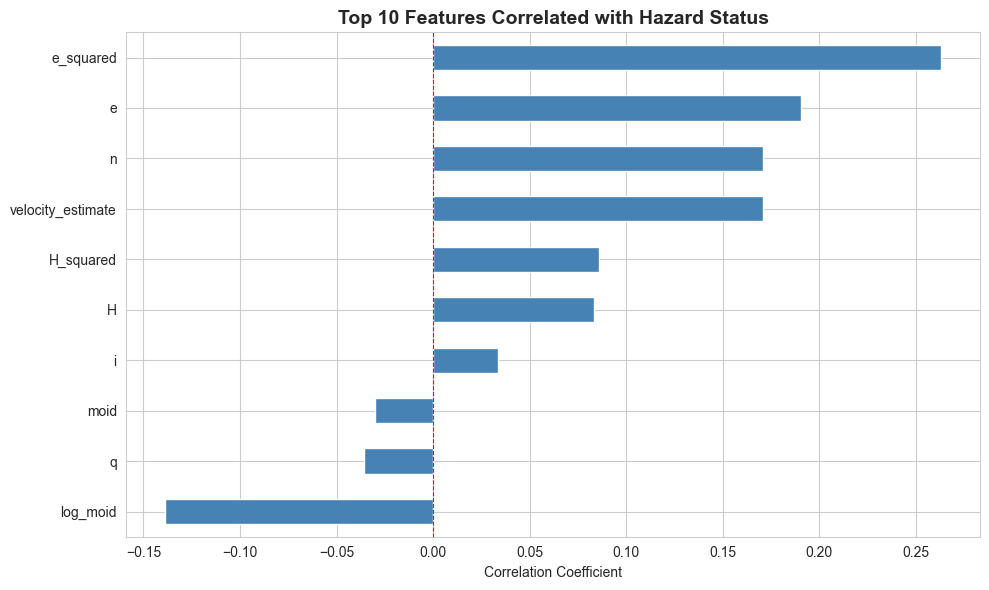

In [4]:
# Show feature correlations with Hazardous
print("="*70)
print("NEW FEATURE CORRELATIONS WITH HAZARDOUS")
print("="*70)

# Calculate correlations
correlations = df_work.corr()['Hazardous'].sort_values(ascending=False)
print(correlations)

# Visualize top features
top_features = correlations.abs().nlargest(11).index[1:]  # Exclude Hazardous itself

plt.figure(figsize=(10, 6))
correlations[top_features].sort_values().plot(kind='barh', color='steelblue')
plt.title('Top 10 Features Correlated with Hazard Status', fontsize=14, fontweight='bold')
plt.xlabel('Correlation Coefficient')
plt.axvline(x=0, color='red', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.savefig('../../figures/day2_feature_correlations.png', dpi=300, bbox_inches='tight')
print("\n✅ Saved: figures/day2_feature_correlations.png")
plt.show()



In [5]:
print("="*70)
print("HANDLING MISSING VALUES")
print("="*70)

# Check missing values
missing = df_work.isnull().sum()
missing_pct = (missing / len(df_work)) * 100

missing_df = pd.DataFrame({
    'Feature': missing.index,
    'Missing_Count': missing.values,
    'Missing_Percentage': missing_pct.values
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

if len(missing_df) > 0:
    print(missing_df.to_string(index=False))
    
    # Strategy: Drop rows with missing Hazardous; impute others with median
    print("\n📊 Strategy: Drop rows with missing target; impute features with median")
    
    # Drop rows where Hazardous is missing
    df_work = df_work.dropna(subset=['Hazardous'])
    print(f"✅ After dropping missing target: {df_work.shape[0]:,} rows")
    
    # Impute missing feature values with median
    feature_cols = [col for col in df_work.columns if col != 'Hazardous']
    
    imputer = SimpleImputer(strategy='median')
    df_work[feature_cols] = imputer.fit_transform(df_work[feature_cols])
    
    print(f"✅ Imputed missing values in {len(feature_cols)} features using median")
    
    # Verify no missing values remain
    remaining_missing = df_work.isnull().sum().sum()
    print(f"✅ Remaining missing values: {remaining_missing}")
else:
    print("✅ No missing values found!")

print(f"\n✅ Final dataset: {df_work.shape[0]:,} rows × {df_work.shape[1]} columns")


HANDLING MISSING VALUES
           Feature  Missing_Count  Missing_Percentage
          diameter         822315           85.789714
              moid          19921            2.078300
         Hazardous          19921            2.078300
          log_moid          19921            2.078300
moid_e_interaction          19921            2.078300
                 H           6263            0.653400
         H_squared           6263            0.653400

📊 Strategy: Drop rows with missing target; impute features with median
✅ After dropping missing target: 938,603 rows
✅ Imputed missing values in 16 features using median
✅ Remaining missing values: 0

✅ Final dataset: 938,603 rows × 17 columns


In [6]:
print("="*70)
print("FEATURE SELECTION")
print("="*70)

# Keep top features based on correlation
# Select features with |correlation| > 0.05 with Hazardous
threshold = 0.05
high_corr_features = correlations[correlations.abs() > threshold].index.tolist()
high_corr_features.remove('Hazardous')  # Remove target

print(f"Features with |correlation| > {threshold}:")
for feat in high_corr_features:
    print(f"  - {feat}: {correlations[feat]:.4f}")

# Create selected feature dataset
selected_features = high_corr_features + ['Hazardous']
df_selected = df_work[selected_features].copy()

print(f"\n✅ Selected {len(high_corr_features)} features for modeling")
print(f"✅ Dataset shape: {df_selected.shape}")


FEATURE SELECTION
Features with |correlation| > 0.05:
  - e_squared: 0.2631
  - e: 0.1905
  - n: 0.1709
  - velocity_estimate: 0.1709
  - H_squared: 0.0860
  - H: 0.0832
  - log_moid: -0.1387

✅ Selected 7 features for modeling
✅ Dataset shape: (938603, 8)


In [8]:
print("="*70)
print("FEATURE SCALING")
print("="*70)

# Separate features and target
X = df_selected.drop('Hazardous', axis=1)
y = df_selected['Hazardous']

print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")
print(f"Class distribution: {y.value_counts().to_dict()}")

# Scale features using StandardScaler (mean=0, std=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame to keep column names
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

print(f"\n✅ Features scaled using StandardScaler")
print(f"✅ Mean ≈ 0, Std ≈ 1 for all features")

# Show before/after example for any available feature
if len(X.columns) > 0:
    example_feature = X.columns[0]  # Use first available feature
    print(f"\nExample feature ({example_feature}) before/after scaling:")
    print(f"  Before: mean={X[example_feature].mean():.4f}, std={X[example_feature].std():.4f}")
    print(f"  After:  mean={X_scaled_df[example_feature].mean():.4f}, std={X_scaled_df[example_feature].std():.4f}")



FEATURE SCALING
Features (X): (938603, 7)
Target (y): (938603,)
Class distribution: {0.0: 936537, 1.0: 2066}

✅ Features scaled using StandardScaler
✅ Mean ≈ 0, Std ≈ 1 for all features

Example feature (e_squared) before/after scaling:
  Before: mean=0.0330, std=0.0505
  After:  mean=-0.0000, std=1.0000


✅ Saved: figures/day2_feature_distributions.png


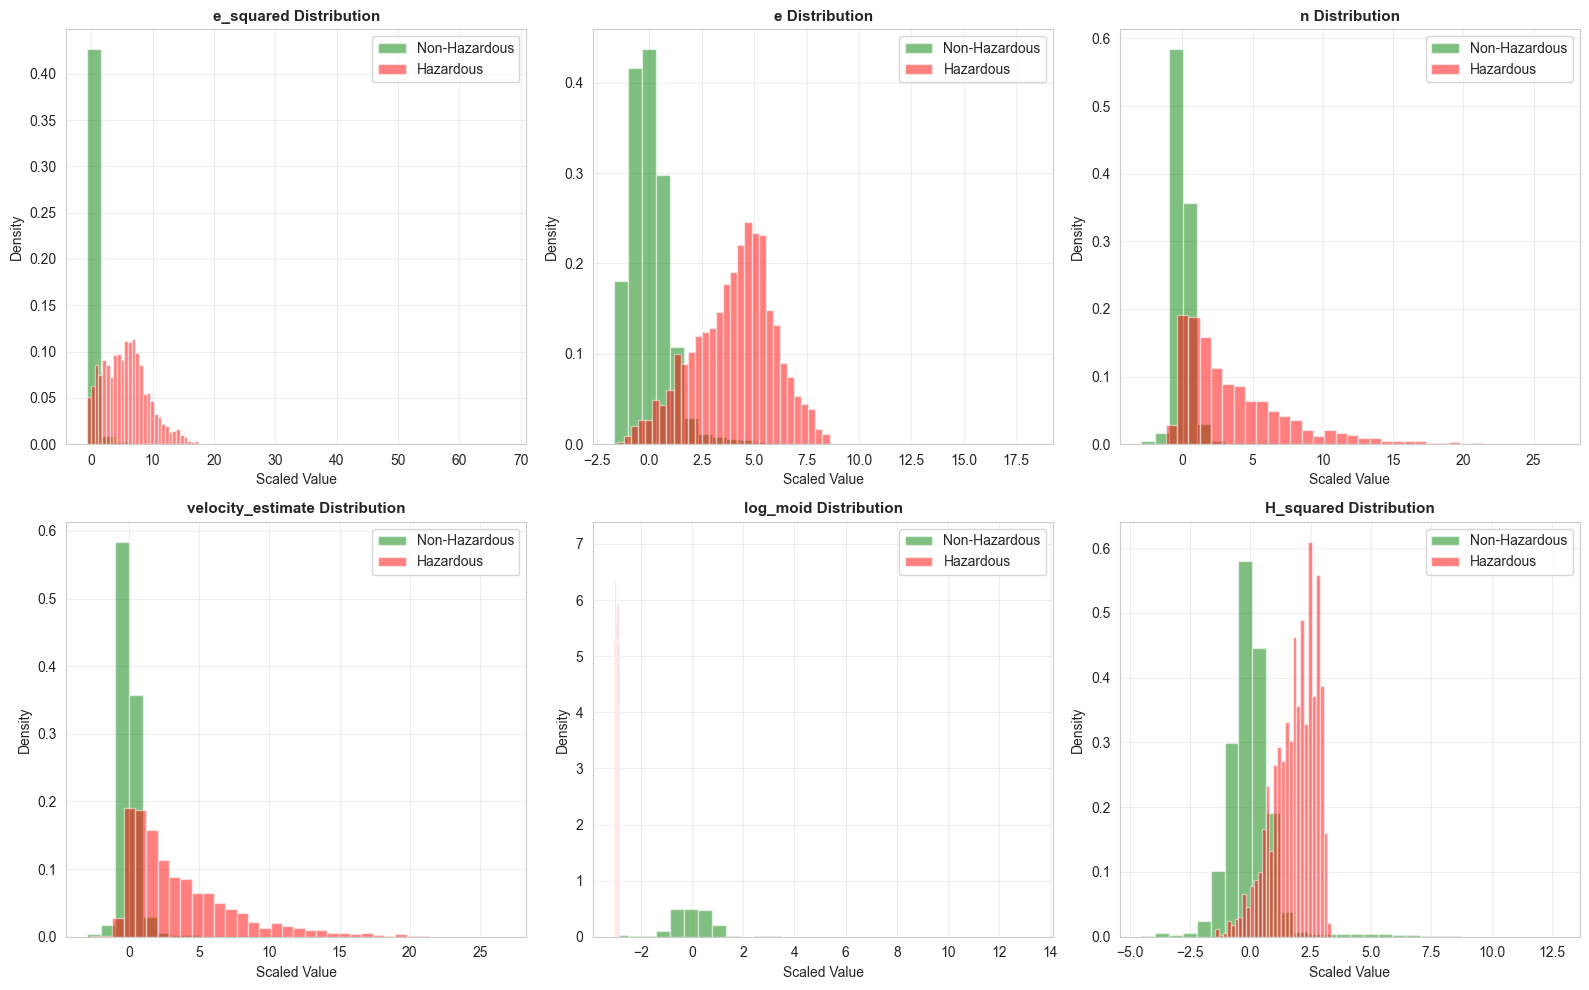

In [9]:
# Compare distributions: Hazardous vs Non-Hazardous
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

# Select 6 most important features
top_6_features = correlations.abs().nlargest(7).index[1:7]  # Exclude Hazardous

for idx, feature in enumerate(top_6_features):
    ax = axes[idx]
    
    # Plot distributions for both classes
    X_scaled_df[y == 0][feature].hist(bins=30, alpha=0.5, label='Non-Hazardous', 
                                       ax=ax, color='green', density=True)
    X_scaled_df[y == 1][feature].hist(bins=30, alpha=0.5, label='Hazardous', 
                                       ax=ax, color='red', density=True)
    
    ax.set_title(f'{feature} Distribution', fontsize=11, fontweight='bold')
    ax.set_xlabel('Scaled Value')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../figures/day2_feature_distributions.png', dpi=300, bbox_inches='tight')
print("✅ Saved: figures/day2_feature_distributions.png")
plt.show()


In [10]:
print("="*70)
print("SAVING PROCESSED DATASET")
print("="*70)

# Combine scaled features with target
df_processed = X_scaled_df.copy()
df_processed['Hazardous'] = y.values

# Save to CSV
output_path = '../../data/processed/asteroid_processed.csv'
df_processed.to_csv(output_path, index=False)

print(f"✅ Saved processed dataset: {output_path}")
print(f"✅ Shape: {df_processed.shape}")
print(f"✅ Features: {len(df_processed.columns) - 1}")
print(f"✅ Rows: {len(df_processed):,}")

# Also save feature names and scaler for later use
import pickle

# Save scaler
scaler_path = '../../models/scaler.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"✅ Saved scaler: {scaler_path}")

# Save feature names
feature_names = X.columns.tolist()
features_path = '../../output/feature_names.txt'
with open(features_path, 'w') as f:
    f.write('\n'.join(feature_names))
print(f"✅ Saved feature names: {features_path}")


SAVING PROCESSED DATASET
✅ Saved processed dataset: ../../data/processed/asteroid_processed.csv
✅ Shape: (938603, 8)
✅ Features: 7
✅ Rows: 938,603
✅ Saved scaler: ../../models/scaler.pkl
✅ Saved feature names: ../../output/feature_names.txt


In [11]:
print("="*70)
print("DAY 2 COMPLETE - SUMMARY")
print("="*70)

print(f"""
✅ ACCOMPLISHED TODAY:
   • Engineered 7 new features from orbital parameters
   • Handled missing values (median imputation)
   • Selected {len(high_corr_features)} high-correlation features
   • Scaled features using StandardScaler (mean=0, std=1)
   • Saved processed dataset for Day 3 SMOTE

📊 FEATURE ENGINEERING RESULTS:
   • Original features: 8
   • Engineered features: 7
   • Total features: {len(X.columns)}
   • Most important: {correlations.abs().nlargest(4).index[1:4].tolist()}

💾 SAVED FILES:
   • data/processed/asteroid_processed.csv ({df_processed.shape[0]:,} rows)
   • models/scaler.pkl (for deployment)
   • figures/day2_feature_correlations.png
   • figures/day2_feature_distributions.png
   • output/feature_names.txt

🎯 DATASET READY FOR DAY 3:
   • Rows: {len(df_processed):,}
   • Features: {len(df_processed.columns) - 1}
   • Class imbalance: 596:1 (will fix with SMOTE tomorrow!)
   • All features scaled and clean

📅 TOMORROW (Day 3):
   1. Apply SMOTE to balance 596:1 → 1:1
   2. Test SMOTE variants (SMOTE-Tomek, SMOTE-ENN)
   3. Save balanced dataset
   4. Ready for model training (Day 4)!

🎉 Day 2 Status: COMPLETE AND SUCCESSFUL!
""")


DAY 2 COMPLETE - SUMMARY

✅ ACCOMPLISHED TODAY:
   • Engineered 7 new features from orbital parameters
   • Handled missing values (median imputation)
   • Selected 7 high-correlation features
   • Scaled features using StandardScaler (mean=0, std=1)
   • Saved processed dataset for Day 3 SMOTE

📊 FEATURE ENGINEERING RESULTS:
   • Original features: 8
   • Engineered features: 7
   • Total features: 7
   • Most important: ['e_squared', 'e', 'n']

💾 SAVED FILES:
   • data/processed/asteroid_processed.csv (938,603 rows)
   • models/scaler.pkl (for deployment)
   • figures/day2_feature_correlations.png
   • figures/day2_feature_distributions.png
   • output/feature_names.txt

🎯 DATASET READY FOR DAY 3:
   • Rows: 938,603
   • Features: 7
   • Class imbalance: 596:1 (will fix with SMOTE tomorrow!)
   • All features scaled and clean

📅 TOMORROW (Day 3):
   1. Apply SMOTE to balance 596:1 → 1:1
   2. Test SMOTE variants (SMOTE-Tomek, SMOTE-ENN)
   3. Save balanced dataset
   4. Ready for mod

In [12]:
# Before imputation
df_raw = pd.read_csv('../../data/raw/asteroid.csv')
df_raw['Hazardous'] = df_raw['pha'].map({'Y': 1, 'N': 0})

hazardous_missing_moid = df_raw[df_raw['Hazardous']==1]['moid'].isnull().sum()
total_hazardous = df_raw[df_raw['Hazardous']==1].shape[0]

print(f"Hazardous asteroids with missing MOID: {hazardous_missing_moid}/{total_hazardous} ({hazardous_missing_moid/total_hazardous*100:.1f}%)")


Hazardous asteroids with missing MOID: 0/2066 (0.0%)


In [13]:
print("="*70)
print("MOID THRESHOLD ANALYSIS")
print("="*70)

# Check MOID distribution for both classes
hazardous_moid = df_work[df_work['Hazardous']==1]['moid']
safe_moid = df_work[df_work['Hazardous']==0]['moid']

print(f"\n📊 Hazardous Asteroids (n={len(hazardous_moid):,}):")
print(f"   MOID < 0.05 AU: {(hazardous_moid < 0.05).sum():,} ({(hazardous_moid < 0.05).sum()/len(hazardous_moid)*100:.1f}%)")
print(f"   MOID ≥ 0.05 AU: {(hazardous_moid >= 0.05).sum():,} ({(hazardous_moid >= 0.05).sum()/len(hazardous_moid)*100:.1f}%)")
print(f"   Mean MOID: {hazardous_moid.mean():.4f} AU")
print(f"   Median MOID: {hazardous_moid.median():.4f} AU")

print(f"\n📊 Non-Hazardous Asteroids (n={len(safe_moid):,}):")
print(f"   MOID < 0.05 AU: {(safe_moid < 0.05).sum():,} ({(safe_moid < 0.05).sum()/len(safe_moid)*100:.1f}%)")
print(f"   MOID ≥ 0.05 AU: {(safe_moid >= 0.05).sum():,} ({(safe_moid >= 0.05).sum()/len(safe_moid)*100:.1f}%)")
print(f"   Mean MOID: {safe_moid.mean():.4f} AU")
print(f"   Median MOID: {safe_moid.median():.4f} AU")

# Confusion at the threshold
print(f"\n⚠️ THRESHOLD OVERLAP:")
print(f"   Non-hazardous with MOID < 0.05: {(safe_moid < 0.05).sum():,}")
print(f"   Hazardous with MOID ≥ 0.05: {(hazardous_moid >= 0.05).sum():,}")
print(f"\n→ This overlap weakens linear correlation!")


MOID THRESHOLD ANALYSIS

📊 Hazardous Asteroids (n=2,066):
   MOID < 0.05 AU: 2,066 (100.0%)
   MOID ≥ 0.05 AU: 0 (0.0%)
   Mean MOID: 0.0237 AU
   Median MOID: 0.0233 AU

📊 Non-Hazardous Asteroids (n=936,537):
   MOID < 0.05 AU: 9,058 (1.0%)
   MOID ≥ 0.05 AU: 927,479 (99.0%)
   Mean MOID: 1.4182 AU
   Median MOID: 1.2422 AU

⚠️ THRESHOLD OVERLAP:
   Non-hazardous with MOID < 0.05: 9,058
   Hazardous with MOID ≥ 0.05: 0

→ This overlap weakens linear correlation!
